<a href="https://colab.research.google.com/github/tuphr2234/ChaosPrediction/blob/main/N_Body_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build Simulation

In [1]:
#pip install anvil-uplink

In [2]:
#import anvil.server

#anvil.server.connect("M2SHTQKH2FUIJQQXXX4VKXEB-I37SIP4DTE6Z5NM3")

In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
import os
from pathlib import Path  


G=1


class Body:
  
  prevPosition=np.array([0,0])
  position=np.array([0,0])
  velocity=np.array([0,0])
  force=np.array([0,0])
  acceleration=np.array([0,0])
  mass=0

  def __init__(self,position=[0,0],velocity=[0,0],mass=1,name="newBody"):
    self.position=np.array(position)
    self.velocity=np.array(velocity)
    #self.acceleration=np.array(acceleration)
    self.mass=mass
    self.prevPosition=np.array(position)
    self.name = name


  def setInitialPostion(self,position):
    self.postion = np.array(position)
    self.prevPosition=np.array(position)

    
  def setInitialVelocity(self,velocity):
    self.velocity = np.array(velocity)

   
  def setInitialMass(self,mass):
    self.mass = mass




  def setPosition(self,t):
    self.prevPosition = self.position
    self.position=self.position+self.velocity*t+(self.acceleration/2)* t**2
  

  def setVelocity(self,t):
    self.velocity=self.velocity+self.acceleration*t
  

  def getForce(self,body):
    softening = 0.01
    Distance = body.prevPosition - self.position
    Rsquare = Distance[0]**2 + Distance[1]**2 #+ softening
    #F = G* self.mass*body.mass / Rsquare  
    F = (G* self.mass*body.mass / Rsquare) - 0.001 / (Rsquare * Rsquare) ### Lennard-Jones like force
    normalizeDis = Distance / math.sqrt(Rsquare)
    F = F*normalizeDis
  #  if math.sqrt(Rsquare) < softening:
  #    F = -F 
    
    return F

  def setAcceleration(self,bodies):
    F=np.array([0,0])
    for body in bodies:
      F=F+self.getForce(body)
    self.acceleration = F/self.mass
   # print(f" {self.name} acceleration is {self.acceleration}")

In [4]:
def centerOfMass(vect):
  out =np.array([0,0])
  for i in range(0,len(vect),2):
    out = out + np.array(vect[i],vect[i+1])
  return out / (len(vect)//2) 

In [5]:

def simulateOnTimeStep(bodies,t,steps,interval_in_data): # bodies: list of bodies. t: timestep . steps: number of steps. interval_in_data : frequency of rows taken to dataset: if equals 1 than it is every step
  dataset = []

  for i in range(steps):
      list1=[]
      for body in bodies:
        list1.append(body.position)
      if i % interval_in_data ==0:
        dataset += list1
      
      for i,body in enumerate(bodies):
        body.setAcceleration([b for b in bodies if b is not body])
        body.setVelocity(t)
        body.setPosition(t)
       
        
      for body in bodies:
        body.prevPosition = body.position
    

  return np.array(dataset).reshape(steps//interval_in_data,len(bodies),2)



In [6]:
def numpyToPandas(simulation,numOfBodies):
  columns = []

  for i in range(numOfBodies):
    columns.append(f'Body{i+1} x')
    columns.append(f'Body{i+1} y')
  simulation_reshaped = simulation.reshape(len(simulation), numOfBodies*2 )

  df = pd.DataFrame(simulation_reshaped, columns = columns)
  return df


Add Filters

In [7]:
def addNoise(simulation):
  noise = np.random.normal(0, .1, simulation.shape)
  return simulation + noise
def removeBody(simulation, bodyNum):
  del1 = np.delete(simulation,(bodyNum-1)*2,1)
  return np.delete(del1,(bodyNum-1)*2,1)

Save Simulation

In [8]:
## save simulation as csv
def saveSimulation(simulation,numOfBodies,simulation_name):
  df = numpyToPandas(simulation,numOfBodies) 
  df.to_csv(f'/content/{simulation_name}.csv',index=False)
  
def loadSimulation(df):
  return pd.DataFrame.to_numpy(df)  

Prepare Dataset 

In [9]:
def prepareData(simulation,window_size_X,window_size_y): 
  X = []
  y = []
  for i in range(len(simulation)-window_size_X - window_size_y):
    row = [bodies for bodies in simulation[i:i+window_size_X]]  
    X.append(row)
    label =  [bodies for bodies in simulation[i+window_size_X:i+window_size_X + window_size_y]]#######################################
    y.append(label)

  return np.array(X) , np.array(y)


In [10]:
def createRandomTrainingSetForPreTrainedModel():
    randomSimulations = []
    numOfSimulations = 5
    X_trainArr = [None]*numOfSimulations
    y_trainArr = [None]*numOfSimulations
    for i in range(numOfSimulations):
      randomSimulations.append(createRandomSimulation(4,timestep,steps,interval_in_data))
      X_trainArr[i], y_trainArr[i] = prepareData(train,windowSizeX,windowSizeY)

 #   for i in range(len(randomSimulations)):
      saveSimulation(randomSimulations[i],numOfBodies,f"{numOfBodies}-Body Simulation{i+20}")


    return X_trainArr, y_trainArr

In [11]:

def trainOnRandomSimulations(epochs, numOfSimulations, X_trainArr,y_trainArr):

    for i in range(epochs):
      for j in range(numOfSimulations):
      #model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, callbacks=[cp1])
      #history = model.fit(X_train, y_train, epochs=1, callbacks=[cp1])
        history = model.fit(X_trainArr[i], y_trainArr[i], epochs=1, callbacks=[cp1])
        

In [12]:
def splitToTrainValidTest(dataset,testPercentage):
  trainLen = round((len(dataset)*(1-testPercentage-0.05)))
  valLen = round((len(dataset)*0.05))
  train_set = dataset[:trainLen]
  val_set = dataset[trainLen:trainLen+valLen]
  test_set = dataset[trainLen+valLen:]
  return train_set,val_set,test_set

In [77]:
def drawSimulation(simulation):
  prev = np.copy(simulation[0])
  numOfBodies = len(simulation[0])
  from random import randint
  colors = []

  for i in range(30):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

  #colors = ['red','green','blue','yellow','black','brown','purple','pink',]
  for i,sim in enumerate(simulation):
    if i == 0:
      continue
    for j in range(0,len(sim),2):
      plt.plot([prev[j],sim[j]],[prev[j+1],sim[j+1]],  color = colors[j // 2])
      prev[j] = np.copy(sim[j])
      prev[j+1] = np.copy(sim[j+1])
  plt.show()


In [14]:
def showBodiesMovmentInGraph(simulation):
  plt.title("X body coordinate")
  for i in range(0,len(simulation.columns),2):
      df = simulation.iloc[:,i]
      plt.plot(df)
  plt.show()
  plt.title("Y body coordinate")
  for i in range(1,len(simulation.columns),2):
      df = simulation.iloc[:,i]
      plt.plot(df)
  plt.show()




Preprocessing/Postprocessing

Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def buildModelCNN(window_size_X,window_size_y,numberOfBodies): 
  model = Sequential()
 # model.add(InputLayer((window_size_X,numberOfBodies*2)))


  model.add(tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(window_size_X, numberOfBodies*2, 1)))
  model.add(tf.keras.layers.Conv2D(32, (5,5), padding="same", activation="relu", input_shape=(window_size_y, numberOfBodies*2, 1)))

  #model.add(Conv1D(64, kernel_size=2)) ###
  #model.add(Dropout(0.2))
 # model.add(Conv1D(32, kernel_size=(3,3))) ###
  model.add(Flatten())
  #model.add(LSTM(32))
  #model.add(Dropout(0.2))
  #model.add(Dense(16, 'relu'))
  model.add(Dense(units =  window_size_y*numberOfBodies*2, activation ='linear'))
  model.add(tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))
  model.summary()
  return model

In [16]:
model = buildModelCNN(100,100, 4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 8, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 8, 32)        25632     
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 800)               20480800  
                                                                 
 reshape (Reshape)           (None, 100, 8)            0         
                                                                 
Total params: 20,506,752
Trainable params: 20,506,752
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def inception_module(x, base_channels=32):
  a = Conv2D(base_channels*2, 1, 1, activation='relu')(x)

  b_1 = Conv2D(base_channels*2, 1, 1, activation='relu')(x)
  b_2 = Conv2D(base_channels*4, 3, 1, padding='same', activation='relu')(b_1)

  c_1 = Conv2D(base_channels, 1, 1, activation='relu')(x)
  c_2 = Conv2D(base_channels, 5, 1, padding='same', activation='relu')(c_1)

 # d_1 = MaxPooling2D(3, 1, padding='same')(x)
 # d_2 = Conv2D(base_channels, 1, 1, activation='relu')(d_1)




  return Concatenate(axis=-1)([a, b_2, c_2])

def Inceptionmodel(window_size_X,window_size_y,numberOfBodies):

  inp = Input((window_size_X, numberOfBodies*2, 1))

  maps_1 = inception_module(inp)
  maps_2 = inception_module(maps_1, base_channels=16)

  gap = GlobalMaxPooling2D()(maps_2)
  
  output = Dense(window_size_y * numberOfBodies*2, activation='linear')(gap)
  output = (tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))(output)
  model = Model(inputs=inp, outputs=output)
  model.summary()
  return model

In [18]:
#model = model(100,100, 4)

ValueError: ignored

In [19]:
def slidingWindowActualPredictions(model,windowArr,windowSize,NumOfBodies,predictionsRequestedNumber): ### One step at a time autoregression
  

  actualPredictionArr =[]
  for i in range(predictionsRequestedNumber):

    prediction = model.predict(windowArr[-1:]) ### predict from last window
    actualPredictionArr.append(prediction)
    temp = np.zeros([windowSize,numOfBodies*2])
    temp = temp + windowArr[-1]
    temp =temp[1:]
    newWindow = np.append(temp.reshape(windowSize-1,numOfBodies*2),prediction)
    newWindow = newWindow.reshape(windowSize,numOfBodies*2)
    lengthX = len(windowArr)
    windowArr = np.append(windowArr,newWindow) ### add new window that the last vector is the prediction 
    windowArr = windowArr.reshape(lengthX+1,windowSize,numOfBodies*2)

  return actualPredictionArr

In [20]:
def preprocessSimulation(simulation):
  shape = simulation[0].shape
  newSimulation = np.append(simulation[1:],[np.zeros(shape)],axis=0) - simulation
  newSimulation = newSimulation[:-1]
  for i,s in enumerate(newSimulation):
    s = s / np.linalg.norm(simulation[i])
  return newSimulation

In [21]:
def postprocess(lastKnownElement , listOfPredictedChanges):
  listOfPredictions = []
  for pred in listOfPredictedChanges:
    #newElement = (pred * np.linalg.norm(lastKnownElement)) + lastKnownElement
    newElement = pred  + lastKnownElement
    listOfPredictions.append(newElement)
    lastKnownElement = newElement
  return np.array(listOfPredictions)  


In [22]:
def createRandomSimulation(numOfBodies,timestep,steps,interval_in_data):
  bodies =[]
  for i in range(numOfBodies):
    bodies.append( Body( np.array([np.random.uniform(-1,1),np.random.uniform(-1,1)]), np.array([np.random.uniform(-1,1) , np.random.uniform(-1,1)]) , 1 ) )

  simulation = simulateOnTimeStep(bodies,timestep,steps,interval_in_data)
  simulation=simulation.reshape(len(simulation), numOfBodies*2 )
  return simulation   

Training Model

In [ ]:
#Body(position,velocity,mass,name)
#%%timeit


bodies=[]


bodies.append(Body([0.97000436,-0.29308753],[0,0],1,"body1"))
bodies.append(Body([-0.97000436,0.24308753],[0,0],1,"body2"))
bodies.append(Body([0, 0],[-0,-0],1,"body3"))
bodies.append(Body([0.3, 0.24308753],[0, 0],1,"body4"))
bodies.append(Body([0.3, -0.24308753],[0, 0],1,"body4"))
bodies.append(Body([-0.3, 0.24308753],[0, 0],1,"body4"))




##########################################

# The 8 Figure motion initials

#bodies.append(Body([-0.97000436, 0.24308753],[0.4662036850, 0.4323657300],1,"body1"))
#bodies.append(Body([0.97000436, -0.24308753],[0.4662036850, 0.4323657300],1,"body2"))
#bodies.append(Body([0, 0],[-0.93240737, -0.86473146],1,"body3"))

##########################################



numOfBodies=len(bodies)
##t: timestep . steps: number of steps. interval_in_data
timestep = 0.001 # actual seconds
steps = 122000
#steps = 3000000
interval_in_data = 500

simulation1 = simulateOnTimeStep(bodies,timestep,steps,interval_in_data)
simulation1=simulation1.reshape(len(simulation1), numOfBodies*2 )
saveSimulation(simulation1,numOfBodies,f"{numOfBodies}-Body Simulation")


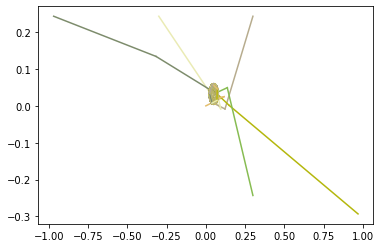

In [78]:
drawSimulation(simulation1)


In [24]:
'''

##t: timestep . steps: number of steps. interval_in_data
timestep = 0.001 # actual seconds
steps = 122000
#steps = 3000000
interval_in_data = 500


createRandomTrainingSetForPreTrainedModel()
'''

'\n\n##t: timestep . steps: number of steps. interval_in_data\ntimestep = 0.001 # actual seconds\nsteps = 122000\n#steps = 3000000\ninterval_in_data = 500\n\n\ncreateRandomTrainingSetForPreTrainedModel()\n'

In [25]:
#simulation1 = simulation1[:,2:8]


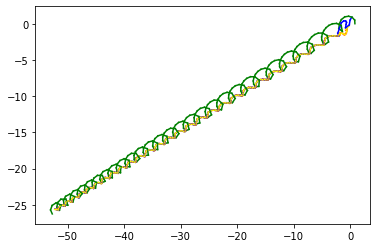

In [52]:
#simulation1 = loadSimulation(pd.read_csv(f'/content/4-Body Simulation23.csv'))
#drawSimulation(simulation1)

In [79]:
numOfBodies = simulation1.shape[1] // 2

In [ ]:
showBodiesMovmentInGraph(numpyToPandas(simulation1,numOfBodies))

In [82]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert
scaled = False 

batch = 128

diffSimulation1 = np.diff(simulation1,axis = 0)
#diffSimulation1 = preprocessSimulation(simulation1)
#diffSimulation1 = np.diff(simulation1[:,2:8],axis = 0)
train, val, test = splitToTrainValidTest(diffSimulation1,0.05)


windowSizeX=100#len(test)
windowSizeY =100#len(test)


if scaled:
  scaler = StandardScaler()
  scaler.fit(simulation1[:len(train)+len(val)])
  #valScaler.fit(train)  ### train / val as input ? 

  train = scaler.transform(train)
  val = scaler.transform(val)
  #train = hilbert(train)
  #val = hilbert(val)

X_train, y_train = prepareData(train,windowSizeX,windowSizeY)
X_val, y_val = prepareData(val,windowSizeX,windowSizeY)
X_test, y_test = prepareData(test,windowSizeX,windowSizeY)


model =  buildModelCNN(windowSizeX,windowSizeY,numOfBodies)
#model =  model(windowSizeX,windowSizeY,numOfBodies)
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])




#generator = TimeseriesGenerator(train_scaled,train_scaled,length = len(test),batch_size=batch)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 12, 32)       320       
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 12, 32)       25632     
                                                                 
 flatten_4 (Flatten)         (None, 38400)             0         
                                                                 
 dense_4 (Dense)             (None, 1200)              46081200  
                                                                 
 reshape_4 (Reshape)         (None, 100, 12)           0         
                                                                 
Total params: 46,107,152
Trainable params: 46,107,152
Non-trainable params: 0
_________________________________________________________________


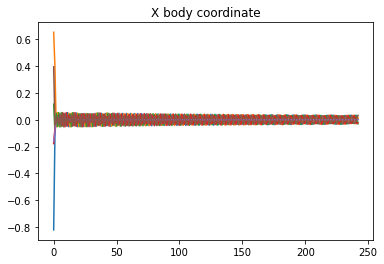

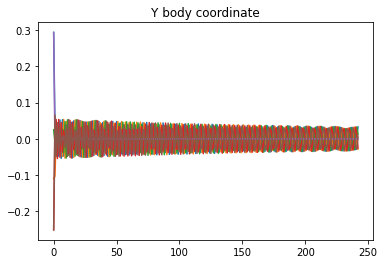

In [83]:
showBodiesMovmentInGraph(numpyToPandas(diffSimulation1,numOfBodies))

In [100]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1])

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 1.3360e-06 - root_mean_squared_error: 0.0012

1/1 [==============================] - 0s 62ms/step - loss: 1.3360e-06 - root_mean_squared_error: 0.0012
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 1.2353e-06 - root_mean_squared_error: 0.0011

1/1 [==============================] - 0s 39ms/step - loss: 1.2353e-06 - root_mean_squared_error: 0.0011
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 1.1382e-06 - root_mean_squared_error: 0.0011

1/1 [==============================] - 0s 39ms/step - loss: 1.1382e-06 - root_mean_squared_error: 0.0011
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 1.0455e-06 - root_mean_squared_error: 0.0010

1/1 [==============================] - 0s 46ms/step - loss: 1.0455e-06 - root_mean_squared_error: 0.0010
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 9.7206e-07 - root_mean_squared_error: 9.8593e-04

1/1 [==============================] - 0s 41ms/step - loss: 9.7206e-07 - root_mean_squared_error: 9.8593e-04
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 9.1980e-07 - root_mean_squared_error: 9.5906e-04

1/1 [==============================] - 0s 39ms/step - loss: 9.1980e-07 - root_mean_squared_error: 9.5906e-04
Epoch 7/50
1/1 [==============================] - ETA: 0s - loss: 8.7626e-07 - root_mean_squared_error: 9.3609e-04

1/1 [==============================] - 0s 37ms/step - loss: 8.7626e-07 - root_mean_squared_error: 9.3609e-04
Epoch 8/50
1/1 [==============================] - ETA: 0s - loss: 8.3046e-07 - root_mean_squared_error: 9.1130e-04

1/1 [==============================] - 0s 39ms/step - loss: 8.3046e-07 - root_mean_squared_error: 9.1130e-04
Epoch 9/50
1/1 [==============================] - ETA: 0s - loss: 7.8321e-07 - root_mean_squared_error: 8.8499e-04

1/1 [==============================] - 0s 39ms/step - loss: 7.8321e-07 - root_mean_squared_error: 8.8499e-04
Epoch 10/50
1/1 [==============================] - ETA: 0s - loss: 7.4166e-07 - root_mean_squared_error: 8.6120e-04

1/1 [==============================] - 0s 37ms/step - loss: 7.4166e-07 - root_mean_squared_error: 8.6120e-04
Epoch 11/50
1/1 [==============================] - ETA: 0s - loss: 7.0542e-07 - root_mean_squared_error: 8.3989e-04

1/1 [==============================] - 0s 48ms/step - loss: 7.0542e-07 - root_mean_squared_error: 8.3989e-04
Epoch 12/50
1/1 [==============================] - ETA: 0s - loss: 6.6663e-07 - root_mean_squared_error: 8.1647e-04

1/1 [==============================] - 0s 39ms/step - loss: 6.6663e-07 - root_mean_squared_error: 8.1647e-04
Epoch 13/50
1/1 [==============================] - ETA: 0s - loss: 6.2369e-07 - root_mean_squared_error: 7.8974e-04

1/1 [==============================] - 0s 39ms/step - loss: 6.2369e-07 - root_mean_squared_error: 7.8974e-04
Epoch 14/50
1/1 [==============================] - ETA: 0s - loss: 5.8347e-07 - root_mean_squared_error: 7.6385e-04

1/1 [==============================] - 0s 39ms/step - loss: 5.8347e-07 - root_mean_squared_error: 7.6385e-04
Epoch 15/50
1/1 [==============================] - ETA: 0s - loss: 5.4985e-07 - root_mean_squared_error: 7.4152e-04

1/1 [==============================] - 0s 43ms/step - loss: 5.4985e-07 - root_mean_squared_error: 7.4152e-04
Epoch 16/50
1/1 [==============================] - ETA: 0s - loss: 5.1937e-07 - root_mean_squared_error: 7.2067e-04

1/1 [==============================] - 0s 37ms/step - loss: 5.1937e-07 - root_mean_squared_error: 7.2067e-04
Epoch 17/50
1/1 [==============================] - ETA: 0s - loss: 4.8888e-07 - root_mean_squared_error: 6.9920e-04

1/1 [==============================] - 0s 45ms/step - loss: 4.8888e-07 - root_mean_squared_error: 6.9920e-04
Epoch 18/50
1/1 [==============================] - ETA: 0s - loss: 4.6085e-07 - root_mean_squared_error: 6.7886e-04

1/1 [==============================] - 0s 43ms/step - loss: 4.6085e-07 - root_mean_squared_error: 6.7886e-04
Epoch 19/50
1/1 [==============================] - ETA: 0s - loss: 4.3799e-07 - root_mean_squared_error: 6.6181e-04

1/1 [==============================] - 0s 42ms/step - loss: 4.3799e-07 - root_mean_squared_error: 6.6181e-04
Epoch 20/50
1/1 [==============================] - ETA: 0s - loss: 4.1849e-07 - root_mean_squared_error: 6.4691e-04

1/1 [==============================] - 0s 40ms/step - loss: 4.1849e-07 - root_mean_squared_error: 6.4691e-04
Epoch 21/50
1/1 [==============================] - ETA: 0s - loss: 3.9916e-07 - root_mean_squared_error: 6.3179e-04

1/1 [==============================] - 0s 39ms/step - loss: 3.9916e-07 - root_mean_squared_error: 6.3179e-04
Epoch 22/50
1/1 [==============================] - ETA: 0s - loss: 3.7974e-07 - root_mean_squared_error: 6.1623e-04

1/1 [==============================] - 0s 41ms/step - loss: 3.7974e-07 - root_mean_squared_error: 6.1623e-04
Epoch 23/50
1/1 [==============================] - ETA: 0s - loss: 3.6180e-07 - root_mean_squared_error: 6.0150e-04

1/1 [==============================] - 0s 38ms/step - loss: 3.6180e-07 - root_mean_squared_error: 6.0150e-04
Epoch 24/50
1/1 [==============================] - ETA: 0s - loss: 3.4596e-07 - root_mean_squared_error: 5.8818e-04

1/1 [==============================] - 0s 37ms/step - loss: 3.4596e-07 - root_mean_squared_error: 5.8818e-04
Epoch 25/50
1/1 [==============================] - ETA: 0s - loss: 3.3080e-07 - root_mean_squared_error: 5.7515e-04

1/1 [==============================] - 0s 44ms/step - loss: 3.3080e-07 - root_mean_squared_error: 5.7515e-04
Epoch 26/50
1/1 [==============================] - ETA: 0s - loss: 3.1514e-07 - root_mean_squared_error: 5.6137e-04

1/1 [==============================] - 0s 37ms/step - loss: 3.1514e-07 - root_mean_squared_error: 5.6137e-04
Epoch 27/50
1/1 [==============================] - ETA: 0s - loss: 3.0022e-07 - root_mean_squared_error: 5.4793e-04

1/1 [==============================] - 0s 40ms/step - loss: 3.0022e-07 - root_mean_squared_error: 5.4793e-04
Epoch 28/50
1/1 [==============================] - ETA: 0s - loss: 2.8728e-07 - root_mean_squared_error: 5.3598e-04

1/1 [==============================] - 0s 39ms/step - loss: 2.8728e-07 - root_mean_squared_error: 5.3598e-04
Epoch 29/50
1/1 [==============================] - ETA: 0s - loss: 2.7514e-07 - root_mean_squared_error: 5.2454e-04

1/1 [==============================] - 0s 39ms/step - loss: 2.7514e-07 - root_mean_squared_error: 5.2454e-04
Epoch 30/50
1/1 [==============================] - ETA: 0s - loss: 2.6283e-07 - root_mean_squared_error: 5.1267e-04

1/1 [==============================] - 0s 41ms/step - loss: 2.6283e-07 - root_mean_squared_error: 5.1267e-04
Epoch 31/50
1/1 [==============================] - ETA: 0s - loss: 2.5126e-07 - root_mean_squared_error: 5.0125e-04

1/1 [==============================] - 0s 39ms/step - loss: 2.5126e-07 - root_mean_squared_error: 5.0125e-04
Epoch 32/50
1/1 [==============================] - ETA: 0s - loss: 2.4116e-07 - root_mean_squared_error: 4.9108e-04

1/1 [==============================] - 0s 41ms/step - loss: 2.4116e-07 - root_mean_squared_error: 4.9108e-04
Epoch 33/50
1/1 [==============================] - ETA: 0s - loss: 2.3210e-07 - root_mean_squared_error: 4.8177e-04

1/1 [==============================] - 0s 42ms/step - loss: 2.3210e-07 - root_mean_squared_error: 4.8177e-04
Epoch 34/50
1/1 [==============================] - ETA: 0s - loss: 2.2335e-07 - root_mean_squared_error: 4.7260e-04

1/1 [==============================] - 0s 39ms/step - loss: 2.2335e-07 - root_mean_squared_error: 4.7260e-04
Epoch 35/50
1/1 [==============================] - ETA: 0s - loss: 2.1480e-07 - root_mean_squared_error: 4.6346e-04

1/1 [==============================] - 0s 39ms/step - loss: 2.1480e-07 - root_mean_squared_error: 4.6346e-04
Epoch 36/50
1/1 [==============================] - ETA: 0s - loss: 2.0691e-07 - root_mean_squared_error: 4.5487e-04

1/1 [==============================] - 0s 37ms/step - loss: 2.0691e-07 - root_mean_squared_error: 4.5487e-04
Epoch 37/50
1/1 [==============================] - ETA: 0s - loss: 1.9959e-07 - root_mean_squared_error: 4.4676e-04

1/1 [==============================] - 0s 41ms/step - loss: 1.9959e-07 - root_mean_squared_error: 4.4676e-04
Epoch 38/50
1/1 [==============================] - ETA: 0s - loss: 1.9223e-07 - root_mean_squared_error: 4.3844e-04

1/1 [==============================] - 0s 37ms/step - loss: 1.9223e-07 - root_mean_squared_error: 4.3844e-04
Epoch 39/50
1/1 [==============================] - ETA: 0s - loss: 1.8486e-07 - root_mean_squared_error: 4.2995e-04

1/1 [==============================] - 0s 39ms/step - loss: 1.8486e-07 - root_mean_squared_error: 4.2995e-04
Epoch 40/50
1/1 [==============================] - ETA: 0s - loss: 1.7801e-07 - root_mean_squared_error: 4.2191e-04

1/1 [==============================] - 0s 38ms/step - loss: 1.7801e-07 - root_mean_squared_error: 4.2191e-04
Epoch 41/50
1/1 [==============================] - ETA: 0s - loss: 1.7172e-07 - root_mean_squared_error: 4.1440e-04

1/1 [==============================] - 0s 37ms/step - loss: 1.7172e-07 - root_mean_squared_error: 4.1440e-04
Epoch 42/50
1/1 [==============================] - ETA: 0s - loss: 1.6556e-07 - root_mean_squared_error: 4.0688e-04

1/1 [==============================] - 0s 38ms/step - loss: 1.6556e-07 - root_mean_squared_error: 4.0688e-04
Epoch 43/50
1/1 [==============================] - ETA: 0s - loss: 1.5933e-07 - root_mean_squared_error: 3.9917e-04

1/1 [==============================] - 0s 40ms/step - loss: 1.5933e-07 - root_mean_squared_error: 3.9917e-04
Epoch 44/50
1/1 [==============================] - ETA: 0s - loss: 1.5333e-07 - root_mean_squared_error: 3.9157e-04

1/1 [==============================] - 0s 39ms/step - loss: 1.5333e-07 - root_mean_squared_error: 3.9157e-04
Epoch 45/50
1/1 [==============================] - ETA: 0s - loss: 1.4760e-07 - root_mean_squared_error: 3.8419e-04

1/1 [==============================] - 0s 40ms/step - loss: 1.4760e-07 - root_mean_squared_error: 3.8419e-04
Epoch 46/50
1/1 [==============================] - ETA: 0s - loss: 1.4195e-07 - root_mean_squared_error: 3.7676e-04

1/1 [==============================] - 0s 38ms/step - loss: 1.4195e-07 - root_mean_squared_error: 3.7676e-04
Epoch 47/50
1/1 [==============================] - ETA: 0s - loss: 1.3644e-07 - root_mean_squared_error: 3.6937e-04

1/1 [==============================] - 0s 39ms/step - loss: 1.3644e-07 - root_mean_squared_error: 3.6937e-04
Epoch 48/50
1/1 [==============================] - ETA: 0s - loss: 1.3135e-07 - root_mean_squared_error: 3.6243e-04

1/1 [==============================] - 0s 40ms/step - loss: 1.3135e-07 - root_mean_squared_error: 3.6243e-04
Epoch 49/50
1/1 [==============================] - ETA: 0s - loss: 1.2674e-07 - root_mean_squared_error: 3.5600e-04

1/1 [==============================] - 0s 37ms/step - loss: 1.2674e-07 - root_mean_squared_error: 3.5600e-04
Epoch 50/50
1/1 [==============================] - ETA: 0s - loss: 1.2242e-07 - root_mean_squared_error: 3.4988e-04

1/1 [==============================] - 0s 40ms/step - loss: 1.2242e-07 - root_mean_squared_error: 3.4988e-04


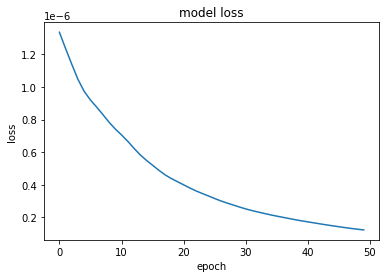

In [101]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
#history = model.fit_generator(generator,epochs=100,verbose=1)

Predictions

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
#predictions = model.predict(X_test)          ###############  LOCAL RMSE  (prediction per window on test set)
#predictions = postprocess(val[-1],predictions)
#predictions = scaler.inverse_transform(predictions)
#print(math.sqrt(mean_squared_error(y_test,predictions)))
#print(math.sqrt(mean_squared_error(y_test.reshape(len(X_test),windowSizeY*numOfBodies*2),predictions.reshape(len(X_test),windowSizeY*numOfBodies*2))))


In [102]:
predictions = model.predict(X_train[-1:])
predictions=predictions.squeeze()

# One-shot prediction : 
actualPredictions = postprocess(simulation1[len(X_train)+windowSizeX-1],predictions)
##### ACTUAL RMSE #####
print(math.sqrt(mean_squared_error(postprocess(simulation1[len(X_train)-1],diffSimulation1[len(X_train):len(X_train)+windowSizeY]),actualPredictions)))


0.04186903377156996


In [40]:
#######  Autoregressive prediction - Only in case Y window is in size 1 ######
import math

if windowSizeY == 1:

    AutoregressivePredictions = slidingWindowActualPredictions(model,X_train,windowSizeX,numOfBodies,len(test))
    AutoregressivePredictions =np.array(AutoregressivePredictions)
    AutoregressivePredictions = AutoregressivePredictions.squeeze()

    actualPredictions = postprocess(simulation1[len(X_train)+len(test)-1],AutoregressivePredictions)

    if scaled:
      actualPredictions = scaler.inverse_transform(actualPredictions)
  ##### ACTUAL RMSE #####
    print(math.sqrt(mean_squared_error(postprocess(simulation1[len(X_train)-1],diffSimulation1[len(X_train):len(X_train)+windowSizeY]),actualPredictions)))

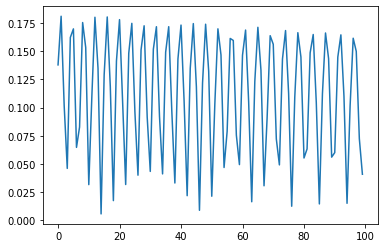

In [103]:
### Distance at each point throught the prediction
import matplotlib.pyplot as plt
disArr = []
#for i in range(len(val)+len(test)):
  #disArr.append(np.linalg.norm(simulation1[len(X_train)+windowSizeX+i+1]-listOfPredictionsTrue[i]))
for i in range(windowSizeY):
  disArr.append(np.linalg.norm(postprocess(simulation1[len(X_train)+windowSizeX-1],diffSimulation1[len(X_train)+windowSizeX:len(X_train)+windowSizeX+windowSizeY])[i]-actualPredictions[i]))

plt.plot(disArr)  

In [106]:
def draw_real_vs_prediction(real,simulated,i=0,j=100):
  plt.title(f"Real Trajectory in range {i}-{j}")
  drawSimulation(real[i:j])
  plt.title(f"Predicted Trajectory in range {i}-{j}")
  drawSimulation(simulated[i:j])



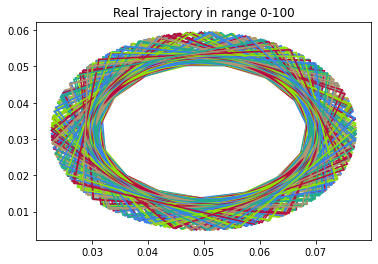

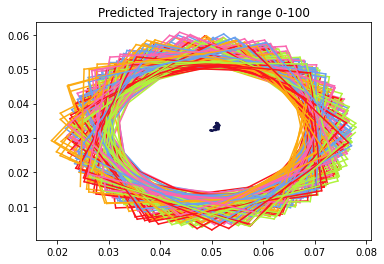

In [107]:
real = simulation1[len(X_train)+ windowSizeX: len(X_train) + windowSizeX + windowSizeY ]
simulated = actualPredictions
draw_real_vs_prediction(real, simulated)